In [4]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

image = 'data/catdog.jpg'
    
    
# Load the model
model = YOLO('pretrained/yolov8n.pt')  # load a pretrained model

# Perform inference
results = model(source=image, conf=0.5)
names = model.names


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax, class_name=''):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    ax.text(x0, y0-10, f"{class_name}") 

# results.show()


image 1/1 /home/briancqi/Desktop/SAM_RAM_SC/data/catdog.jpg: 448x640 1 cat, 1 dog, 62.5ms
Speed: 2.7ms preprocess, 62.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


In [2]:
classess = []
for result in results:
    boxes = result.boxes
    for c in boxes.cls:
        classess.append(names[int(c)])
    
lst_boxes = boxes.xyxy.tolist()
print(len(lst_boxes))
print(classess)
bbox = lst_boxes[1]
print(bbox)

2
['cat', 'dog']
[29.89776611328125, 0.0, 468.0247497558594, 535.7625732421875]


In [3]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2

image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
sam_checkpoint = "pretrained/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)
predictor.set_image(image)


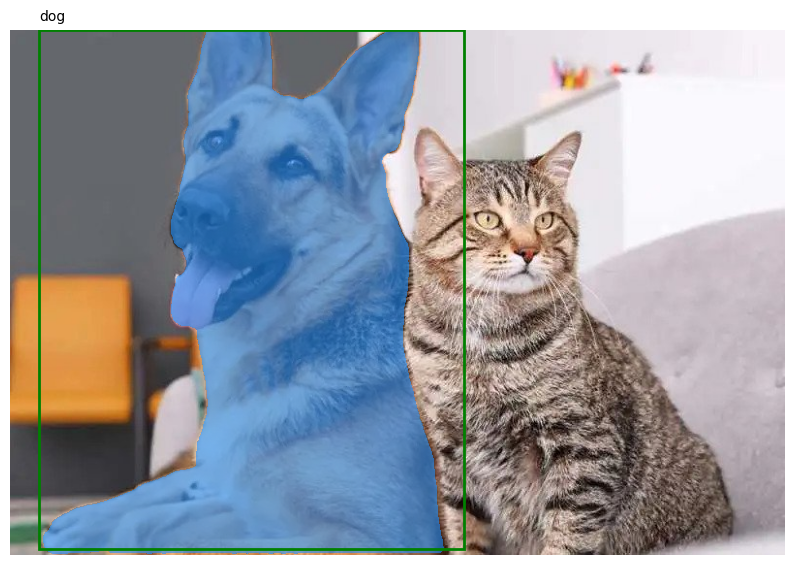

In [4]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca(), classess[1])
plt.axis('off')
plt.show()

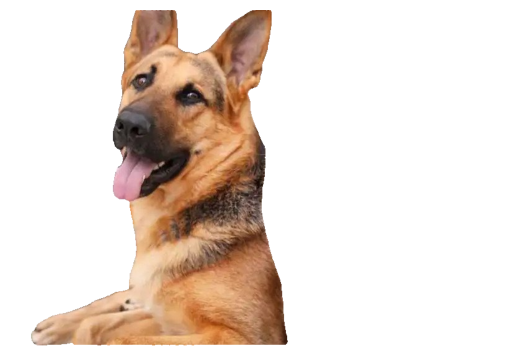

In [5]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

[406.45440673828125, 96.56517028808594, 746.4937744140625, 536.6697998046875]
[29.89776611328125, 0.0, 468.0247497558594, 535.7625732421875]


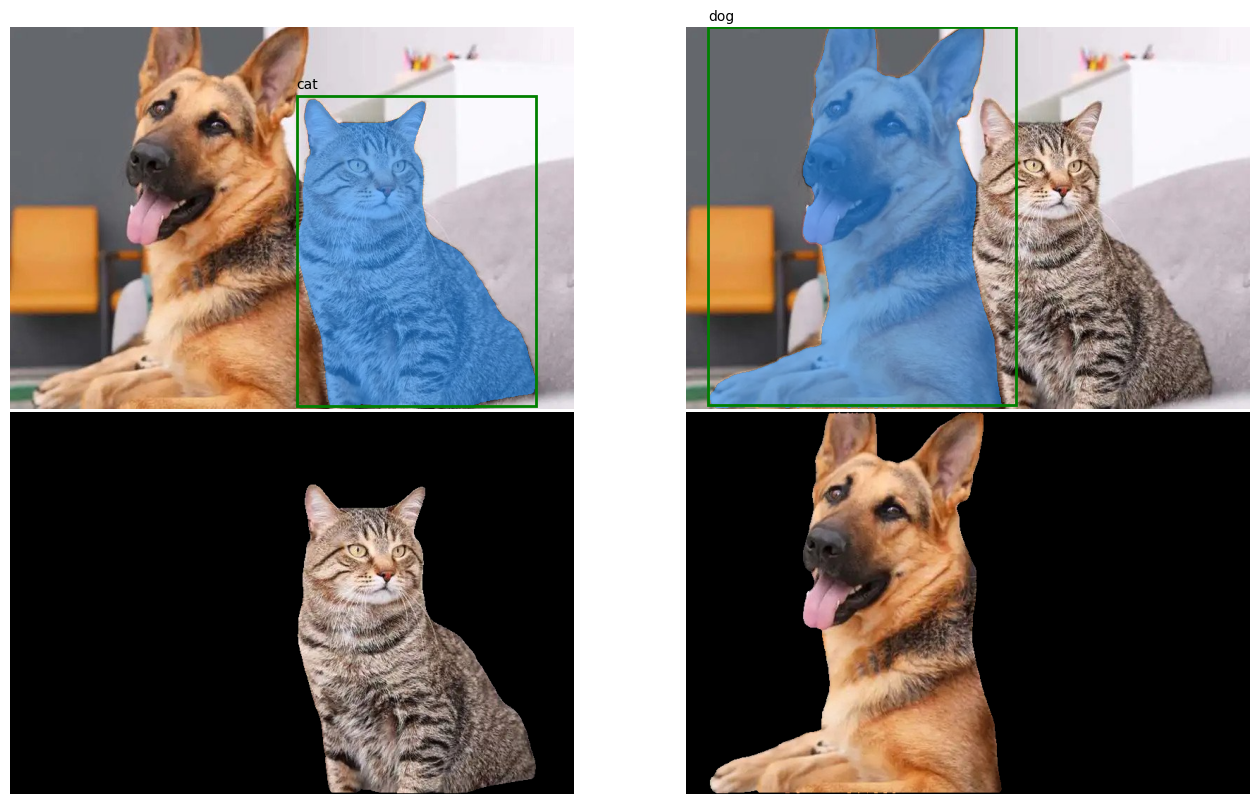

In [6]:
import shutil

# Define the directory path
directory = "data/masks"

# Empty the directory if it exists
if os.path.exists(directory):
    shutil.rmtree(directory)

# Create the directory
os.makedirs(directory)

num_images = len(lst_boxes)
fig, axes = plt.subplots(2, num_images, figsize=(8*num_images, 10))

for i, box in enumerate(lst_boxes):
    input_box = np.array(box)
    print(box)
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )

    # Display original image with mask and box
    axes[0, i].imshow(image)
    show_mask(masks[0], axes[0, i])
    show_box(input_box, axes[0, i], classess[i])
    axes[0, i].axis('off')

    # Create cut object
    segmentation_mask = masks[0]
    binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

    black_background = np.zeros_like(image) 

    new_image = black_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]
    
    save_path = os.path.join(directory, f"mask_{i}.jpg")
    plt.imsave(save_path, new_image.astype(np.uint8))

    # Display cut object in the bottom
    axes[1, i].imshow(new_image.astype(np.uint8))
    axes[1, i].axis('off')

plt.subplots_adjust(hspace=0)  # Adjust the spacing between subplots
plt.show()

In [11]:
# Train the semantic communication channel and save encoder decoder into /models/
import torch
from codes.semantic.sc1 import SemanticCommunicationChannel, SemanticEncoder, SemanticDecoder
from codes.train_semantic import train_semantic_communication_system
from codes.calculate.noise import add_awgn_noise, add_rayleigh_noise
from codes.calculate.metrics import calculate_psnr, calculate_miou, calculate_compression_rate
from codes.calculate.utils import load_images, reshape_images_to_tensor, save_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Load images to train the semantic communication channel
MASK_DIR = "data/original"
images = load_images(MASK_DIR)
num_images = images.size(0)
image_channels = images.size(1)
image_height = images.size(2)
image_width = images.size(3)

# Reshape images tensor to fit the semantic encoder input shape
images = images.view(num_images, image_channels, image_height, image_width)

# Prepare train channel
num_epochs = 20000
batch_size = 64
channel = SemanticCommunicationChannel()
encoder, decoder = train_semantic_communication_system(channel=channel, images=images, device=device, num_epochs=num_epochs, batch_size=batch_size)
save_model(encoder, "encoder_sc1")
save_model(decoder, "decoder_sc1")

/home/briancqi/anaconda3/envs/sam/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([70, 3, 512, 512])) that is different to the input size (torch.Size([1, 3, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 100/20000, Loss: 0.9450899958610535
Epoch: 200/20000, Loss: 0.7333452701568604
Epoch: 300/20000, Loss: 0.5692253708839417
Epoch: 400/20000, Loss: 0.4423738121986389
Epoch: 500/20000, Loss: 0.345245361328125
Epoch: 600/20000, Loss: 0.27166783809661865
Epoch: 700/20000, Loss: 0.21638792753219604
Epoch: 800/20000, Loss: 0.17525067925453186
Epoch: 900/20000, Loss: 0.14498497545719147


: 

: 

In [8]:
# Load the model
from torchinfo import summary

encoder = SemanticEncoder()
decoder = SemanticDecoder()
encoder_state_dict = torch.load('models/encoder_sc1.pt', map_location=device)
decoder_state_dict = torch.load('models/decoder_sc1.pt', map_location=device)

encoder.load_state_dict(encoder_state_dict)
decoder.load_state_dict(decoder_state_dict)
encoder.eval()
decoder.eval()
encoder.to(device)
decoder.to(device)
# print(summary(encoder, input_size=(2, 3, 512, 512)))

# Load images to Test over channel
MASK_DIR = "data/masks"
images = load_images(MASK_DIR)
num_images = images.size(0)
image_channels = images.size(1)
image_height = images.size(2)
image_width = images.size(3)
images = images.view(num_images, image_channels, image_height, image_width)

images = images.to(device)
snr_list = np.arange(1,30)  # dB
psnr_list, psnr_list_r = [], []

encoder_images = encoder(images)

for snr in snr_list: 
    noisy_images = add_awgn_noise(encoder_images, snr)
    noisy_images = noisy_images.to(device)
    restored_images = decoder(noisy_images)
    rm = restored_images
    #rm = restored_images.sum(dim=0).unsqueeze(0)
    # ensure noisy_images are on the correct device
    noisy_images_r = add_rayleigh_noise(encoder_images, snr)
    noisy_images_r = noisy_images_r.to(device)
    restored_images_r = decoder(noisy_images_r)
    rm_r = restored_images_r
    #rm_r = restored_images_r.sum(dim=0).unsqueeze(0)
    #restored_im = restored_images.sum(dim=0).unsqueeze(0)

    theta = 1.0
    psnr = calculate_psnr(images.unsqueeze(0).to(device), rm, theta)
    psnr_list.append(psnr.item())
    
    psnr_r = calculate_psnr(images.unsqueeze(0).to(device), rm_r, theta)
    psnr_list_r.append(psnr_r.item())
    
    # if snr == 20:  # check if snr is 20
    #     # plot encoder_image, noisy_image and decoder_image
    #     fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    #     axs[0].imshow(encoder_images.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
    #     axs[0].set_title('Original Image')
    #     axs[1].imshow(noisy_images.transpose(1,2,0))
    #     axs[1].set_title('Restored Image (RF)')
    #     axs[2].imshow(restored_images.transpose(1,2,0))
    #     axs[2].set_title('Restored Image (AWGN)')
    #     axs[0].axis('off')
    #     axs[1].axis('off')
    #     axs[2].axis('off')
        
        # fig, ax = plt.subplots(1, 3)  # create a figure with 3 subplots
        # ax[0].imshow(encoder_images.squeeze().detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')  # plot encoder_image
        # ax[0].set_title('Encoder image')
        # ax[1].imshow(noisy_images.squeeze().detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')  # plot noisy_image
        # ax[1].set_title('Noisy image')
        # ax[2].imshow(restored_images.squeeze().detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')  # plot decoder_image
        # ax[2].set_title('Decoder image')
        # plt.show()  # show the figure
    
print(psnr_list)
print(psnr_list_r)

[7.832714080810547, 10.935498237609863, 11.598042488098145, 11.854597091674805, 11.948484420776367, 12.023675918579102, 11.994595527648926, 12.020235061645508, 12.02221965789795, 12.03848934173584, 12.040515899658203, 12.063732147216797, 12.08386516571045, 12.060704231262207, 12.038159370422363, 12.078776359558105, 12.048429489135742, 12.05793285369873, 12.059200286865234, 12.062128067016602, 12.100484848022461, 12.078328132629395, 12.080894470214844, 12.093128204345703, 12.098965644836426, 12.09547233581543, 12.076129913330078, 12.089347839355469, 12.079240798950195]
[10.846410751342773, 11.477998733520508, 11.698848724365234, 11.719371795654297, 11.831212043762207, 11.868714332580566, 11.938484191894531, 11.941810607910156, 11.896627426147461, 11.89776611328125, 11.929459571838379, 11.978702545166016, 11.912728309631348, 11.924835205078125, 11.932979583740234, 12.011628150939941, 12.007314682006836, 11.879217147827148, 11.95864200592041, 11.962030410766602, 11.905289649963379, 11.891

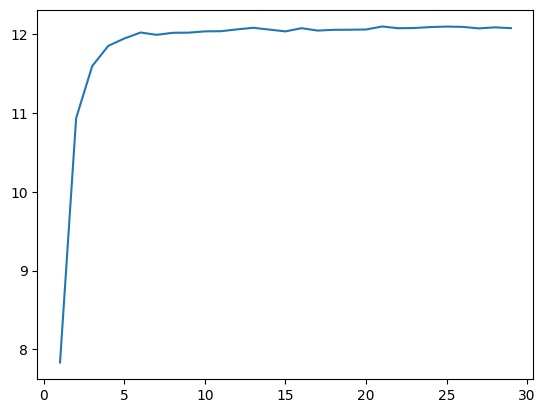

In [9]:
import matplotlib.pyplot as plt

plt.plot(snr_list, psnr_list, label='AWGN')